# 3.2 Milvus 在 RAG (检索增强生成) 中的应用


Milvus 在 RAG（Retrieval-Augmented Generation，检索增强生成）系统中，扮演着“外部知识库”的核心角色。它的主要任务是将经过处理的文档内容转化为高维语义向量，并高效地进行存储与检索。

具体来说，RAG 系统会先将原始文档分成多个文本块，并利用嵌入模型将每个文本块转化为一个语义向量。Milvus 作为向量数据库，将这些文本块连同它们的向量及元数据一同保存。当用户提出问题时，系统会将问题同样转化为向量，并通过 Milvus 快速检索出最相关的文本块。

这些被检索到的文本块，作为知识依据和上下文，被输入到大语言模型中，用于进一步生成符合实际、内容可靠的答案。得益于 Milvus 的高性能向量检索能力，即便面对百万甚至亿级的文档数据，RAG 系统也能在极短时间内给出精准的知识响应。

简而言之，Milvus 是 RAG 体系中的“知识中枢”，保障了外部知识的有效扩展与按需调用。它让大模型生成不再依赖记忆和猜测，而是基于真实的、可追溯的语义资料。这也是现代智能问答系统可信、专业和可扩展的基础之一。



在本章中，我们将系统性回顾 RAG（Retrieval-Augmented Generation，检索增强生成）的核心技术流程，帮助大家从整体上理解这一技术架构是如何工作的。在后续的实验中，我们将基于这些环节逐步搭建一个具备真实问答能力的智能系统。

RAG 的提出，源于传统大语言模型（LLM）存在的两大问题：

1. **记忆范围有限**：模型上下文窗口有限，无法直接处理大体量知识。
2. **容易“胡说”**：模型会根据语义猜测输出内容，可能编造事实（Hallucination）。

而 RAG 的核心思想是：\*\*将检索模块引入生成过程，让模型在生成答案前先“查资料”。\*\*这样可以大幅提升回答的相关性和准确性，尤其适用于企业文档问答、知识库助手、法律法规摘要、技术支持等场景。

RAG 系统通常包含以下六个关键步骤：

```
文档加载 → 分块（Chunking）→ 向量化（Embedding）→ 存储 → 检索 → 生成
```

下面我们逐一简要介绍这六个步骤的意义与要点。

---

### 1️⃣ 文档加载（Document Loading）

这是整个流程的起点。我们需要先将企业内部的知识内容加载进系统中。常见的文档格式包括 `.pdf`、`.txt`、`.md`、`.docx` 等，信息来源可以是本地文件、网页、数据库，甚至是云端文档（如 Notion、Confluence、S3 等）。

在实践中，推荐使用 LangChain 中的 `DocumentLoader` 工具，结合 `Unstructured`、`PyMuPDF`、`pdfplumber` 等库，帮助我们将文档加载为标准的文本数据结构（Document List）。

---

### 2️⃣ 分块（Chunking）

原始文档往往篇幅较长，不适合直接向量化，因此需要进行“分块”处理，将长文档拆解为数百字的短文本块（chunk）。

常见策略包括：

* 固定大小拆分（如每 500 字一个 chunk）
* 滑动窗口拆分（如每 500 字，重叠 100 字）
* 按段落或标题拆分（保留语义完整性）

Chunking 的策略将直接影响后续检索效果：块太小语义不完整，块太大可能模糊焦点。因此，chunk size 和 overlap 是需要调优的重要参数。

---

### 3️⃣ 向量化（Embedding）

每个文本块需要通过语言模型转化为向量，这个向量就是模型所理解的“语义表示”。

常用的嵌入模型包括：

* OpenAI 的 `text-embedding-3-small`
* Sentence Transformers 的 `all-MiniLM-L6-v2`
* Amazon Bedrock 提供的 `Titan Embeddings`
* Cohere 的 `embed-english-light-v3`

生成的向量通常是 384、768 或 1536 维的浮点数组，表示该文本块的语义位置。后续我们可以用这些向量做相似度比较（如余弦相似度）来实现语义检索。

---

### 4️⃣ 存储（Storage）

为了让向量可以随时检索，我们需要将其持久化到向量数据库。
在本流程中，我们选用 Milvus——一款支持亿级数据、性能强劲的开源向量数据库。

Milvus 不仅能保存向量本身，还能同时存储原始文本及元数据（如文档名、段落位置等），方便后续在回答中进行引用。

---

### 5️⃣ 检索（Retrieval）

当用户提出问题时，系统会先将问题进行向量化，然后与数据库中的向量进行相似度搜索，找出最相关的文本块。这个过程就是“语义检索”。

为了提升检索准确性，很多系统还会使用混合检索（Hybrid Search）技术，结合关键词匹配（如 BM25）与语义匹配，或加入 metadata filter 进行限制筛选。

检索结果通常返回 Top-K（如最相关的 3\~5 段）文本块，作为生成模块的输入上下文。

---

### 6️⃣ 生成（Generation）

最后，将检索到的文本块与用户提问一并输入到大语言模型中，由模型基于上下文生成最终答案。

你可以自定义 prompt 模板，如：

```
请根据以下内容回答问题：
{context}

问题：{question}
```

LLM 会参考检索内容进行生成，从而提升准确性、降低幻觉率。

---

通过这六个步骤，我们构建出了一个完整的“从知识库中查找信息并生成回答”的智能问答系统。接下来的实验中，我们将以这一流程为基础，实战搭建一个基于 LangChain 和 Milvus 的 RAG 系统。

## Milvus 在 RAG 中的角色

在构建一个基于 RAG（Retrieval-Augmented Generation，检索增强生成）的问答系统时，很多人第一时间关注的是大语言模型（LLM）的回答能力，然而，真正决定答案质量的往往是模型“看到了什么”。这些“上下文信息”的提供，正是向量数据库的任务。而在众多向量数据库中，**Milvus** 是最常被使用、也最适合工程化落地的一种解决方案。

本章将带大家深入了解：Milvus 在整个 RAG 架构中究竟承担了怎样的角色？它是如何提升问答系统的准确性、效率与可扩展性的？我们又该如何正确地使用它？


### 🧠 在 RAG 流程中的职责

Milvus 在 RAG 系统中主要承担两项关键任务：

#### 1. 存储文本块及其语义向量

RAG 系统的第一步是加载文档，并将其分成若干小段（chunk）。每一段文本都会被一个嵌入模型（如 `all-MiniLM-L6-v2` 或 OpenAI Embedding 模型）转化为一个高维向量。

这些向量不能直接存在内存中，否则随着文档数量增长，系统将无法负载。此时，Milvus 作为向量数据库登场，**它不仅存储这些向量，还一并保存原始文本和元数据（如文件名、页码、段落编号等）**，形成一个完整的语义检索库。

#### 2. 快速检索与用户问题相似的文本块

当用户提出一个自然语言问题时，该问题也会被同样的嵌入模型转化为一个语义向量。这个查询向量会被发送给 Milvus，系统会在存储库中查找与之最接近的 Top-K 向量所对应的文本块。

这一步检索结果将作为**上下文**被喂给 LLM（如 GPT、Claude），成为其回答问题的依据。换句话说，Milvus 决定了 LLM“看到了什么”，而 LLM 决定了“怎么说”。



### 🧪 总结：Milvus 是 RAG 的“记忆中枢”

在 RAG 的六步流程中：

```
文档加载 → 分块（Chunking）→ 向量化（Embedding）→ 存储（Milvus）→ 检索 → 生成
```

Milvus 虽不是回答问题的“主角”，却是整个系统的“记忆中枢”。它让大语言模型具备了“短期记忆之外的长期记忆”，从而能够处理结构化文档、非结构化知识、复杂报告等超出上下文窗口的海量信息。

RAG 的本质是连接检索与生成，而 Milvus 就是这一连接中的桥梁，它保证了系统的可扩展性、准确性与实时性。

---

在接下来的章节中，我们将正式上手：使用 LangChain 将向量数据写入 Milvus，并完成一次真实的问题检索与上下文生成流程。a


# RAG with LangChain & Milvus: Sentence Transformers 本地模型 Demo

> 适合无 OpenAI Key、企业内网、敏感知识库等场景。

**依赖安装**
```bash
pip install langchain pymilvus sentence-transformers ollama
```

我的测试环境供参考：Python 3.12,依赖版本是：
```bash
pip install \
  langchain==0.3.20 \
  pymilvus==2.5.10 \
  sentence-transformers==4.1.0 \
  ollama==0.4.7

```
Milvus 推荐 docker 一键启动，
文档示例路径：docs/**.md


## 0 · 导入依赖 & 环境准备
在正式加载和向量化文档之前，先把所有必需的库导入并建立与 Milvus 的连接。

| 依赖 | 作用 |
|------|------|
| **os** | 读取环境变量、处理文件路径，便于在不同机器上无痛迁移 |
| **TextLoader / DirectoryLoader** | 批量读取单文件或目录下的文本，为后续切分做准备 |
| **RecursiveCharacterTextSplitter** | 将长文档递归切块，保证片段长度均衡且语义完整 |
| **HuggingFaceEmbeddings** | 使用 Hugging Face 模型（如 bge-small、E5）把文本转换成向量 |
| **pymilvus** 模块 | <ul><li>`connections` 建立与 Milvus 的 gRPC 连接</li><li>`FieldSchema` / `CollectionSchema` 声明字段和表结构</li><li>`Collection` 创建或打开向量集合</li><li>`list_collections` 调试时查看现有集合</li></ul> |

> 运行下一个代码单元前，确保已经：
> 1. 启动了 Milvus（Docker Compose 或集群皆可）；
> 2. 在环境变量中设置了 `MILVUS_HOST` 和 `MILVUS_PORT`（默认 19530）；
> 3. 安装好 `langchain`, `sentence-transformers`, `pymilvus` 等依赖（`pip install -r requirements.txt`）。


## 下载并安装 Ollama

1. 打开浏览器访问 [https://ollama.com/download](https://ollama.com/download) 并根据操作系统下载对应安装包。
2. 运行安装包并按提示完成安装。
3. 终端执行 `ollama --version` 确认安装成功。

## 拉取 deepseek-r1:7b 模型

```bash
ollama pull deepseek-r1:7b
```

> 首次拉取约需数分钟（取决于网络与磁盘性能）。下载完可用 `ollama list` 查看本地模型。

## 启动 Ollama 服务

```bash
ollama serve
```

* 默认监听 `127.0.0.1:11434`；如需局域网或远程访问，可在运行前设置

  ```bash
  export OLLAMA_HOST=0.0.0.0:11434
  ```
* 服务启动后，可用 REST API 调用，例如：

  ```bash
  curl http://localhost:11434/api/chat -d '{
    "model":"deepseek-r1:7b",
    "messages":[{"role":"user","content":"你好，介绍一下你自己"}]
  }'
  ```

In [9]:
# 0. 导入依赖 & 环境准备
import os
from langchain.document_loaders import TextLoader, DirectoryLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from pymilvus import connections, FieldSchema, CollectionSchema, DataType, Collection, list_collections

### 📑 文档向量化预处理

> **目标**：把 `docs/` 目录下的所有 Markdown 文件拆分成适合向量化检索的小片段，并准备好本地 MiniLM 模型进行嵌入。

1. **嵌入模型**  
   - 选用 `sentence-transformers/all-MiniLM-L6-v2`（384 维、体积小、通用性强），后续会把每个文本块映射成向量。

2. **批量加载 Markdown**  
   - `DirectoryLoader("docs", glob="**/*.md")` 递归扫描所有 `.md` 文件。  
   - 使用 `TextLoader` 逐个抽取纯文本内容。  
   - 运行后打印“加载文档数”，直观查看读取成果。

3. **文本递归分块**  
   - 采用 `RecursiveCharacterTextSplitter`：  
     - `chunk_size=500`：每块最长 500 字符；  
     - `chunk_overlap=80`：相邻块重叠 80 字符，保证语义连贯。  
   - 分块结果会作为向量化的基本单元，输出“文档共分块”供确认。

> 执行本代码单元后，将得到 `docs` 列表（Document 对象）和 `docs` 切分后的片段列表 `docs`，可以直接用于向量写入和相似度检索。


In [10]:
# 选择本地向量模型
embed_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

# 1. 加载 doc 目录下所有 .md 文件，使用 TextLoader 解析文本内容
loader = DirectoryLoader("docs", glob="**/*.md", loader_cls=TextLoader)
documents = loader.load()
print(f'共加载文档数：{len(documents)}')

# 2. 使用 RecursiveCharacterTextSplitter 分块
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=80)
docs = text_splitter.split_documents(documents)
print(f'文档共分块: {len(docs)} 个')

共加载文档数：4
文档共分块: 121 个


### 🔗 步骤 2：文本向量化

本单元将 **上一步切分好的所有文本块** 转换为稠密向量，以便写入向量数据库并支持后续相似度检索。

1. **提取文本**
   - `texts = [doc.page_content for doc in docs]`  
     将 `Document` 列表提取为纯文本字符串列表，确保不携带多余元数据。

2. **生成向量**
   - `vectors = embed_model.embed_documents(texts)`  
     使用我们选定的 `sentence-transformers/all-MiniLM-L6-v2` 模型（384 维）对全部片段批量嵌入，加速处理。

3. **结果确认**
   - `print(...)` 将输出：  
     - “已完成文本向量化”  
     - 向量维度（应为 **384**），用来验证模型配置正确。

> 执行完本单元后，变量 **`vectors`** 将包含形如 `[N, 384]` 的向量列表，可直接用于写入 Milvus。


In [11]:
# ===== 2. 文本向量化 =====
texts = [doc.page_content for doc in docs]
vectors = embed_model.embed_documents(texts)
print(f'已完成文本向量化，向量维度: {len(vectors[0])}')

已完成文本向量化，向量维度: 384


### 🗄️ 步骤 3：连接 Milvus 并初始化 Collection

这段代码完成了写入向量前的全部准备工作，包含四个环节：

1. **连接数据库**
   `connections.connect(host="localhost", port="19530")`
   与本地 Milvus 实例建立 gRPC 连接，为后续操作铺路。

2. **确定向量维度**
   `dim = len(vectors[0])`
   读取第一条向量的长度（此处应为 384）并记录，后续定义向量字段时用到。

3. **创建或获取 Collection**

   * 如果库里还没有名为 `rag_demo_local` 的 Collection：

     * 定义三列：

       * `id` 主键，自增
       * `embedding` FLOAT\_VECTOR，维度 = `dim`
       * `content` VARCHAR (≤2048)，保存原始文本
     * 以此 Schema 创建新 Collection。
   * 如果同名表已存在，则直接获取并复用。

4. **建立向量索引**
   对 `embedding` 字段创建 **IVF\_FLAT + L2** 索引（`nlist=128`），用于加速相似度搜索。

完成以上四步后，`rag_demo_local` 表已就绪，可立即进行向量批量写入和检索。


In [12]:
# 3. 连接 Milvus 并初始化 Collection
connections.connect(host="localhost", port="19530")
collection_name = "rag_demo_local"
dim = len(vectors[0])

if collection_name not in list_collections():
    fields = [
        FieldSchema(name="id", dtype=DataType.INT64, is_primary=True, auto_id=True),
        FieldSchema(name="embedding", dtype=DataType.FLOAT_VECTOR, dim=dim),
        FieldSchema(name="content", dtype=DataType.VARCHAR, max_length=2048),
    ]
    schema = CollectionSchema(fields)
    collection = Collection(name=collection_name, schema=schema)
    collection.create_index(
        field_name="embedding",
        index_params={"index_type": "IVF_FLAT", "metric_type": "L2", "params": {"nlist": 128}}
    )
else:
    collection = Collection(collection_name)

### 🚀 步骤 4：写入向量到 Milvus

这段代码把之前生成的 **向量 (vectors)** 与其对应 **文本内容 (texts)** 批量写入刚刚创建的 `rag_demo_local` Collection，并立刻让数据可检索：

1. **组装写入数据**

   ```python
   milvus_data = [vectors, texts]
   ```

   Milvus 要求按字段顺序传入二维列表（列优先）。这里顺序与 Schema 对齐：先 `embedding`，再 `content`。

2. **插入记录**

   ```python
   mr = collection.insert(milvus_data)
   ```

   一次性写入全部片段；返回值 `mr` 含自增主键 ID，可用于后续调试或增量更新。

3. **加载到内存**

   ```python
   collection.load()
   ```

   将新建索引段加载到 QueryNode 内存中，确保随即可以执行相似度检索。

4. **结果确认**
   `print(...)` 输出已成功写入的片段数量，验证写入无误。

> 执行完毕后，向量库已准备就绪，后续即可调用 `collection.search()` 进行相似度查询并在 RAG 流程中返回引用片段。


In [13]:
# ===== 4. 插入数据到 Milvus =====
milvus_data = [
    vectors,   # embedding
    texts,     # content
]
mr = collection.insert(milvus_data)
collection.load()
print(f'已插入 {len(texts)} 条分块')


已插入 121 条分块


### 🔍 步骤 5：用户查询并检索相关内容

这段代码演示了 **端到端 RAG** 流程中的“Retrieve”环节：拿到用户提问后，将其向量化并在 Milvus 中做相似度搜索，找出最相关的文本片段。

1. **用户提问 → 向量化**

   ```python
   query_vec = embed_model.embed_query(user_query)
   ```

   把自然语言问题转换成与库中片段同维度的向量，确保度量空间一致。

2. **配置检索参数**

   ```python
   search_params = {"metric_type": "L2", "params": {"nprobe": 10}}
   ```

   * **metric\_type=L2**：与建索引时保持一致。
   * **nprobe=10**：在 10 个倒排簇里细查，提高召回率（可按需求调优）。

3. **执行相似度搜索**

   ```python
   results = collection.search(
       data=[query_vec],
       anns_field="embedding",
       param=search_params,
       limit=4,
       output_fields=["content"]
   )
   ```

   * `limit=4`：最多返回 4 条最相似片段。
   * `output_fields=["content"]`：除了距离分数，还把原始文本字段一起取回。

4. **提取并展示片段**

   ```python
   retrieved_chunks = [hit.entity.get("content") for hit in results[0]]
   ```

   使用简单的 `for` 循环打印前 120 个字符，验证检索效果。

> 至此，你已完成 RAG 的“向量化 → 写库 → 检索”全链路闭环。将 `retrieved_chunks` 作为上下文喂给语言模型，就能生成带引用的最终回答。


In [18]:
# 5. 用户输入问题并检索相关内容
user_query = "怎么使用Docker安装milvus？"
query_vec = embed_model.embed_query(user_query)
search_params = {"metric_type": "L2", "params": {"nprobe": 10}}
results = collection.search(
    data=[query_vec],
    anns_field="embedding",
    param=search_params,
    limit=4,
    output_fields=["content"]
)
retrieved_chunks = [hit.entity.get("content") for hit in results[0]]
for idx, chunk in enumerate(retrieved_chunks, 1):
    print(f'相关片段{idx}：{chunk[:120]}...')

相关片段1：# 在 Docker 中运行 Milvus (Linux)

本页说明如何在 Docker 中启动 Milvus 实例。

## 前提条件

- [安装 Docker](https://docs.docker.com/get-docker/...
相关片段2：# 在 Docker 中运行 Milvus (Linux)

本页说明如何在 Docker 中启动 Milvus 实例。

## 前提条件

- [安装 Docker](https://docs.docker.com/get-docker/...
相关片段3：# 在 Docker 中运行 Milvus (Linux)

本页说明如何在 Docker 中启动 Milvus 实例。

## 前提条件

- [安装 Docker](https://docs.docker.com/get-docker/...
相关片段4：运行安装脚本后

- 一个名为 Milvus 的 docker 容器已在**19530** 端口启动。
- 嵌入式 etcd 与 Milvus 安装在同一个容器中，服务端口为**2379**。它的配置文件被映射到当前文件夹中的**embed...



### 📝 步骤 6：构造 LLM 提示词（Prompt）

> **目的**：把检索到的相关片段 (`retrieved_chunks`) 拼接成上下文，连同用户问题一起组装成给语言模型的最终提示词。

1. **合并检索片段**  
   ```python
   context = '\n'.join(retrieved_chunks)
````

* 用换行符 `\n` 将多个文本片段串联，保持段落分隔，避免信息混淆。
* 得到的 `context` 字符串承载了回答问题所需的事实基础。

2. **生成 Prompt**

   ```python
   prompt = (
       f'已知资料如下：\n{context}\n\n'
       f'请根据以上资料回答用户问题：{user_query}'
   )
   ```

   * 先用中文引导：“已知资料如下：” → 放入 `context` → 再附“请根据以上资料回答用户问题：”。
   * 这种格式让 LLM 明确：**只基于给定资料来回答**，从而减少幻觉并提高可引用性。

完成后，`prompt` 就可以直接送入大语言模型（如 ChatGPT、Claude、Llama 等）生成最终回复。


In [19]:
context = '\n'.join(retrieved_chunks)
prompt = f'已知资料如下：\n{context}\n\n请根据以上资料回答用户问题：{user_query}'

### 🤖 步骤 7：调用本地 LLM 生成最终回答

这段代码把前面检索到的片段喂给本地 Ollama 模型（如 `deepseek-r1:7b`），得到对用户问题的最终回复。流程拆解如下：

1. **拼合检索片段**

   ```python
   context = '\n'.join(retrieved_chunks)
   ```

   用换行符把所有相关片段串成一段长上下文，保持段落清晰。

2. **组装 Prompt**

   ```python
   prompt = (
       f"已知资料如下：\n{context}\n\n"
       f"请根据以上资料回答用户问题：{user_query}"
   )
   ```

   * 明确指示模型“仅依据上述资料”作答，降低幻觉风险。
   * 把用户原始提问 `user_query` 直接附在提示词末尾。

3. **初始化 Ollama 客户端**

   ```python
   client = Client()
   ```

   `ollama-python` 简易 SDK，默认连接本机的 Ollama 服务端口（通常 `127.0.0.1:11434`）。

4. **发送对话请求**

   ```python
   response = client.chat(
       model='deepseek-r1:7b',
       messages=[{'role': 'user', 'content': prompt}]
   )
   ```

   * `model` 指定已在 Ollama 本地拉取的镜像名称（例如 `llama2`、`deepseek-r1:7b`）。
   * `messages` 用 OpenAI Chat 格式，仅含一条用户消息。
   * Ollama 会自动返回 JSON，其中 `response['message']['content']` 即模型生成文本。

5. **打印输出**

   ```python
   print(response['message']['content'])
   ```

   将模型答案直接打印到 Notebook 输出，以便肉眼检查或后续渲染。

> 完成此单元后，RAG 完整链路（**向量检索 → Prompt 构造 → LLM 生成**）即告完成，可在页面上查看对话式回答。


In [20]:
from ollama import Client

context = '\n'.join(retrieved_chunks)

prompt = f"已知资料如下：\n{context}\n\n请根据以上资料回答用户问题：{user_query}"

client = Client()

response = client.chat(
    model='deepseek-r1:7b',  # 例如 'llama2' 或其他
    messages=[{'role': 'user', 'content': prompt}]
)

print(response['message']['content'])


<think>
好，我现在要帮助用户了解如何在Docker中安装Milvus。首先，我得仔细阅读提供的资料，看看里面有没有关于Docker安装的步骤。

看起来资料里有重复的内容，多次提到安装 Docker 和检查硬件软件要求。这可能是个错误或者排版问题。我应该先确认需要哪些前提条件，比如已经安装了 Docker，并且满足了 Milvus 对 Docker 的要求。

接下来，资料提到了一个安装脚本，可以从 Milvus 官方存储库下载：https://raw.githubusercontent.com/milvus-io/milvus/master/scripts/standalone_embed.sh。这一步应该是在Docker中运行的步骤之一。

然后，用户需要运行这个脚本，可能在容器中安装Milvus。安装完成后，会启动一个名为 Milvus 的容器，在19530端口，还有嵌入式etcd服务端口2379。配置文件和数据卷也有说明，方便用户后续设置。

最后，停止和删除容器的方法也给了，使用bash脚本中的stop命令，然后rm命令来删除容器。

不过，我需要确保步骤准确无误，可能还需要补充一些注意事项，比如访问WebUI的地址是否正确，或者其他潜在的问题。同时，如果用户第一次安装可能会遇到路径问题，应该提醒他们注意脚本的执行权限和文件权限设置。
</think>

### 如何在 Docker 中安装 Milvus？

要使用 Docker 安装 Milvus，可以按照以下步骤操作：

---

#### **前提条件**
1. **安装 Docker**：确保已从 [Docker 官方网站](https://docs.docker.com/get-docker/) 下载并运行 Docker。
2. **检查硬件和软件要求**：参考 Milvus 的 [官方文档](https://milvus.io/docs/zh/prerequisite-docker.md)。

---

#### **安装步骤**
1. **获取安装脚本**：
   打开终端，前往 Milvus 官方存储库下载 Milvus 的 Docker 安装脚本：
   ```bash
   git clone https://raw.githubusercontent.com/milvus-i

### RAG、Self-RAG、Agentic RAG、Corrective RAG、Adaptive RAG。

- Standard RAG
这是基础 - 根据相似度检索文档并生成回答。简单、快速，但反馈回路有限。

- Self-RAG
增加了自我反思能力。模型会评估自己的输出，并决定是否需要检索更多信息或重新生成回答;擅长质量控制和有据可依的回答.

- Agentic RAG
走向完全自治 - 将复杂查询拆分成子任务，规划检索策略，并执行多步推理流程。

- Corrective RAG (CRAG)
通过迭代修正聚焦准确性。不断对检索到的知识进行事实核对，并对回答进行精炼修正; 通过持续的纠正循环实现最高准确度.

-  Adaptive RAG
智能切换器 - 根据查询的复杂度、领域和置信度动态选择最佳检索策略; 通过选择合适的方案来提供最佳效率

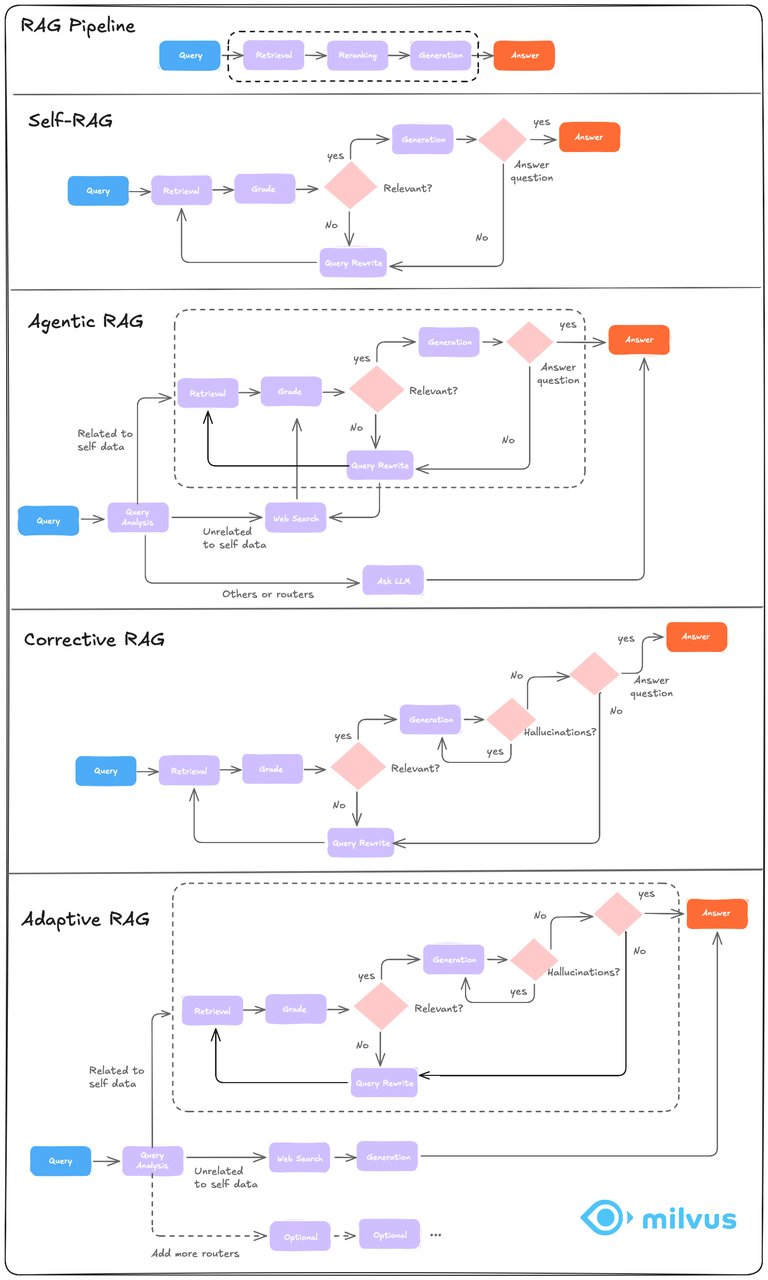


**什么时候应该使用它们？**
- 需要快速入门或追求速度 → 选择 Standard RAG
- 质量和有据可依的回答至关重要 → 选择 Self-RAG
- 需要复杂推理 → 选择 Agentic RAG
- 对关键任务的准确性要求极高 → 选择 CRAG
- 面对多样化查询类型 → 选择 Adaptive RAG

许多人容易犯的错误在于：还没掌握基础就直接跳到复杂的体系架构。
事实上，80% 的生产环境 RAG 系统仍然运行在 Standard RAG 之上，辅以巧妙的优化。

**我们的建议**：先从 Standard RAG 着手，再为质量考虑加入 Self-RAG，之后根据具体需求逐步演进。

 ### Hands-on Exercise 2：尝试修改搜索参数，观察检索结果的变化